__Created By:__ Autumn Stephens <br>
__Creation Date:__ 3/31/2025 <br>
__Last Updated:__ 4/2/2025 <br>

In [2]:
### Necessary imports
import matplotlib.pyplot as plt
import astropy.units as u
import periodictable
import pandas as pd
import numpy as np
import roman

### Imports tools
import ASDtools as asdt

# ___About ASDtools___

This package relies heavily on __[astroquery.nist](https://astroquery.readthedocs.io/en/latest/nist/nist.html)__'s querying capabilities for loading in spectral data for a given element over a range of wavelengths. The main advantage of __ASDtools__ is its ability to format astroquery's default output into a formatted dataframe. Additionally, I have made a handful of helpful tools for visualizing several pieces of the NIST ASD. These visualizations are rough, and still a work in progress, but they should help explain some of the formatting choices seen in NIST's raw data.

__NOTE 1:__ Although I cannot figure out why, __[astroquery.nist](https://astroquery.readthedocs.io/en/latest/nist/nist.html)__'s default output for heavy elements w/o a given ionization will sometimes let the roman numerals for a given element bleed into surrounding columns. I am not sure if this is an issue with my local installation, but I plan to test it more in the coming weeks. If you want to query all elements and ionizations, you will need to independently query each individual element/ionization pair.

__NOTE 2:__ As of writing (March 31, 2025), __[reports have surfaced that the NIST ASD is expected to go offline](https://www.wired.com/story/nist-doge-layoffs-atomic-spectroscopy/)__. In case the actual database is unavailable for querying, compressed files containing the entire database have been saved and uploaded to this GitHub repository. I will be modifying the behavior of __ASDtools__ to use this data as a backup.

# ___Basic Usage (How to Query)___
Since __ASDtools__ uses __astroquery.nist__ to pull its data, it takes the same arguments. However, __ASDtools__ uses a class-based data structure to store and modify NIST ASD data. In order initialize a query, you must create a new "NIST_lines" instance. This initialization takes the same arguments as __astroquery.nist__ (w/ two additional parameters we will discuss later)...

In [5]:
lines = asdt.NIST_lines(["He I", "He II"], 
                        lower_wavelength=3000*u.AA, 
                        upper_wavelength=9000*u.AA)
lines.df

Filtering out flags: 100%|███████████████████████| 8/8 [00:00<00:00, 755.07it/s]


,Element,Observed (nm),Ritz (nm),Transition Type,Rel.,Ei (eV),Ek (eV),Aki,gi,gk,S,Acc.,Lower level,Upper level
0,He I,301.4600,301.459000,E1,40.0,59.673780,63.786580,NaN,9.0,15.0,NaN,,"2p2 | 3P | 0,1,2","2p.3d | 3D* | 1,2,3"
1,He I,NaN,318.865493,E1,NaN,19.819615,23.707906,5636100.0,3.0,1.0,0.000090,AAA,1s.2s | 3S | 1,1s.4p | 3P* | 0
2,He I,318.8667,318.866615,E1,20.0,19.819615,23.707892,5636100.0,3.0,3.0,0.000271,AAA,1s.2s | 3S | 1,1s.4p | 3P* | 1
3,He I,318.8667,318.866706,E1,20.0,19.819615,23.707891,5636100.0,3.0,5.0,0.000451,AAA,1s.2s | 3S | 1,1s.4p | 3P* | 2
4,He I,323.2199,323.220316,E1,0.0,20.615775,24.451678,510150.0,1.0,3.0,0.000026,AAA,1s.2s | 1S | 0,1s.10p | 1P* | 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,He II,NaN,656.199696,E1,NaN,51.016797,52.906225,21979000.0,8.0,10.0,0.030651,AA,4f | 2F* | 7/2,6g | 2G | 9/2
203,He II,NaN,656.200038,E1,NaN,51.016782,52.906209,343510.0,6.0,4.0,0.000192,AA,4f | 2F* | 5/2,6d | 2D | 3/2
204,He II,NaN,656.200041,E1,NaN,51.016782,52.906209,1357200.0,6.0,4.0,0.000757,AA,4d | 2D | 5/2,6p | 2P* | 3/2
205,He II,NaN,656.200630,E1,NaN,51.016797,52.906222,784970.0,8.0,8.0,0.000876,AA,4f | 2F* | 7/2,6g | 2G | 7/2


Notice how...

- Certain column names have explicitly-stated units (for ease of use)
- Numeric columns (i.e., "Observed (nm)", "Aki", etc.) now have NaN values instead of empty strings
- Some columns w/ multiple useful pieces of data have been split up (i.e., "Ei (eV)" and "Ek (eV)")
- Empty entries in the "Transition Type" column now have an explicit type
- Numeric columns no longer contain non-numeric characters (see description of "flags")

These changes were made to reflect some of the struggles I faced when working with data from NIST's ASD. I hope to improve the readability and usefulness of __ASDtools__ in future iterations.

# ___Understanding the Formatted Dataframe___

The default dataframe produced by __ASDtools__ has 14 columns...

1. `Element`: The element symbol and ionization for a given row.
2. `Observed (nm)`: The vacuum wavelength this line has been observed at.
3. `Ritz (nm)`: The Ritz wavelength inferred from the energy levels of the transition.
4. `Transition Type`: Indicates the type of transition rules necessary for the transition (i.e., E1, E2, M1, etc.).
5. `Rel.`: The qualitative relative intensity of lines.
6. `Ei (eV)`: Energy of the lower level (in eV).
7. `Ek (eV)`: Energy of the upper level (in eV).
8. `Aki`: Emission transition probability
9. `gi`: Lower level statistical weight.
10. `gk`: Upper level statistical weight.
11. `S`: Line strength (electric dipole matrix element squared).
12. `Acc.`: 'Accuracy' of the given transition strength (see NIST help doc).
13. `Lower level`: Electronic configuration, term symbol, and J-value of the lower level.
14. `Upper level`: Electronic configuration, term symbol, and J-value of the upper level.

If the user uses the ```keep_flag_columns = True``` argument, __ASDtools__ will attempt to extract and filter out "flags" found within the dataframe. The term "flag" refers to any non-numeric entry in numeric columns. These are not filtered out by __astroquery__, meaning they can interfere with using data directly from the NIST ASD without extra filtering. All flags (if any are found) will be stored in a list in a new columns with the naming convention "{column}_flags". Their meanings are all pulled from the **[NIST ASD Help Page](https://physics.nist.gov/PhysRefData/ASD/Html/lineshelp.html#OUTRELINT)**.

- `*`: Intensity is shared by several lines (typically, for multiply classified lines).
- `:`: Observed value given is actually the rounded Ritz value, e.g., Ar IV, λ = 443.40 Å.
- `-`: Somewhat lower intensity than the value given.
- `?`: This level/line may not be real.
- `†`: Term assignment of the level is questionable.
- `a`: Observed in absorption.
- `bl`: Blended with another line that may affect the wavelength and intensity."
- `b`: Band head.
- `B`: Line or feature having large width due to autoionization broadening.
- `c`: Complex line.
- `d`: Diffuse line.
- `D`: Double line.
- `E`: Broad due to overexposure in the quoted reference.
- `f`: Forbidden line.
- `g`: Transition involving a level of the ground term.
- `G`: Line position roughly estimated.
- `H`: Very hazy line.
- `hfs`: Line has hyperfine structure.
- `h`: Hazy line (same as 'diffuse').
- `i`: Identification uncertain.
- `j`: Wavelength smoothed along isoelectronic sequence.
- `l`: Shaded to longer wavelengths; NB: This may look like a 'one' at the end of the number!
- `m`: Masked by another line (no wavelength measurement).
- `p`: Perturbed by a close line. Both wavelength and intensity may be affected.
- `q`: Asymmetric line.
- `r`: Easily reversed line.
- `s`: Shaded to shorter wavelengths.
- `t`: Tentatively classified line.
- `u`: Unresolved from a close line.
- `+x` : The relative positions of the levels within such a system are accurate within experimental uncertainties, but no experimental connection between this system and the other levels of the spectrum has been made.
- `+y` : The relative positions of the levels within such a system are accurate within experimental uncertainties, but no experimental connection between this system and the other levels of the spectrum has been made.
- `+z` : The relative positions of the levels within such a system are accurate within experimental uncertainties, but no experimental connection between this system and the other levels of the spectrum has been made.
- `w`: Wide line.
- `x`: Extrapolated wavelength.
- `()` : Theoretical value.
- `[]` : This level was determined by interpolation or extrapolation of known experimental values or by semiempirical calculation.

If you would like to see the original columns before any flag extraction was applied, you can use the ```keep_original_columns = True``` argument. This is helpful for checking that my filtering functions are working as intended, so please let me know if you find any errors! If you would like a breakdown of every flag found in your data (along w/ their meaning), you can use the following function...

In [8]:
lines = asdt.NIST_lines("O I", keep_flag_columns=True)
lines.explain_column_flags("Rel.")

Filtering out flags: 100%|███████████████████████| 8/8 [00:00<00:00, 315.11it/s]

   Flag: *
 Counts: 28
Meaning: Intensity is shared by several lines (typically, for multiply classified lines).

   Flag: bl
 Counts: 3
Meaning: Blended with another line that may affect the wavelength and intensity.



# ___Loading the "Complete" NIST ASD___

In order to check that the above functions work for all possible elements, we need to test it for every element, ionization, and wavelength range. I do this by making a list of every valid pair (i.e., "H I", "He II", "He I", "Li I", etc.) and using a large wavelength range (0 AA - 1e7 AA) in my query. Although element symbols w/o ionizations (i.e., "H", "He", "Li", etc.) and "All Spectra" should produce the same result, I struggled to get the table to format correctly for heavy elements.

In [10]:
### Loads all element symbols from the periodic table
el_symbol_list = list(periodictable.elements)

### Adds each possible element/ionization pair to list
elements = []
for e in el_symbol_list:
    ionization = el_symbol_list.index(e)
    for i in range(0, ionization+1):
        elements.append(f"{e} {roman.toRoman(i+1)}")

### Queries the entire database
lines_complete = asdt.NIST_lines(elements, keep_flag_columns=True, keep_original_columns=True)

Filtering out flags: 100%|████████████████████████| 8/8 [00:07<00:00,  1.13it/s]


In [11]:
### Saves processed dataframe to a compressed file
lines_complete.df.to_parquet('NIST_full_processed.gzip', compression='gzip', index=False)
df_loaded = pd.read_parquet('NIST_full_processed.gzip')
df_loaded

,Element,Observed_original,Observed (nm),Ritz_original,Ritz (nm),Ritz_flags,Transition Type,Rel._original,Rel.,Rel._flags,...,Aki_original,Aki,gi_original,gi,gk_original,gk,S,Acc.,Lower level,Upper level
0,H I,nan,NaN,91.232366,91.232366,None,E1,nan,NaN,None,...,122.58,1.225800e+02,2,2.0,3200,3200.0,1.470110e-07,AAA,1s | 2S | 1/2,40 | |
1,H I,nan,NaN,91.2353295,91.235330,None,E1,nan,NaN,None,...,139.13,1.391300e+02,2,2.0,3042,3042.0,1.586363e-07,AAA,1s | 2S | 1/2,39 | |
2,H I,nan,NaN,91.2385303,91.238530,None,E1,nan,NaN,None,...,158.43,1.584300e+02,2,2.0,2888,2888.0,1.715153e-07,AAA,1s | 2S | 1/2,38 | |
3,H I,nan,NaN,91.2419943,91.241994,None,E1,nan,NaN,None,...,181.03,1.810300e+02,2,2.0,2738,2738.0,1.858239e-07,AAA,1s | 2S | 1/2,37 | |
4,H I,nan,NaN,91.2457513,91.245751,None,E1,nan,NaN,None,...,207.62,2.076200e+02,2,2.0,2592,2592.0,2.017788e-07,AAA,1s | 2S | 1/2,36 | |
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296912,Mt CIX,nan,NaN,4.18,4.180000,None,E1,nan,NaN,None,...,nan,NaN,2,2.0,2,2.0,NaN,,2p | 2P* | 1/2,2s | 2S | 1/2
296913,Ds CX,nan,NaN,0.0076794,0.007679,None,E1,nan,NaN,None,...,7.036e+16,7.036000e+16,2,2.0,4,4.0,6.290730e-08,AA,1s | 2S | 1/2,2p | 2P* | 3/2
296914,Ds CX,nan,NaN,0.0082645,0.008264,None,E1,nan,NaN,None,...,9.4452e+16,9.445200e+16,2,2.0,2,2.0,5.262890e-08,AA,1s | 2S | 1/2,2p | 2P* | 1/2
296915,Ds CX,nan,NaN,0.11164,0.111640,None,E1,nan,NaN,None,...,755950000000000.0,7.559500e+14,2,2.0,4,4.0,2.076567e-06,AA,2s | 2S | 1/2,2p | 2P* | 3/2


# ___Atomic Energies (Ei - Ek)___
How do we know the energy associated with a transition? The NIST ASD reports the energy levels of the lower (___Ei___) and upper (___Ek___) states in an electronic transition. The theoretical Ritz wavelength is calulcated using these energy levels, meaning the Ritz wavelength is only as accurate as the corresponding energy values. In the case that these energy levels are unavailable, no Ritz wavelength is reported. Below, we can see how well the energy differences correspond w/ each associated Ritz wavelength...

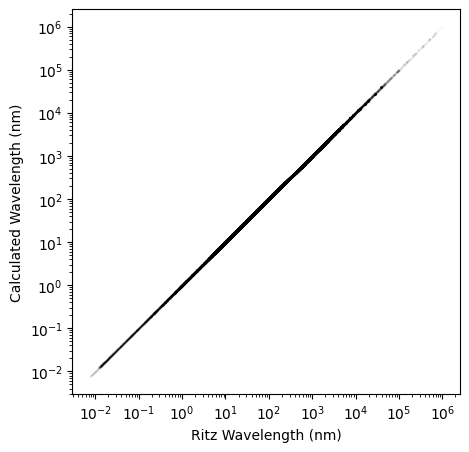

In [13]:
from astropy.constants import h,c

### Loads the necessary data from our dataframe
ritz_wavelengths = np.array(lines_complete.df["Ritz (nm)"])*u.nm
lower_energies = np.array(lines_complete.df["Ei (eV)"])*u.eV
upper_energies = np.array(lines_complete.df["Ek (eV)"])*u.eV

### Calculates the expected wavelength corresponding to the energy difference
calculated_wavelengths = (h*c/(upper_energies-lower_energies)).to(u.nm)

### Plotting
plt.rcParams["figure.figsize"] = (5, 5)
plt.scatter(ritz_wavelengths, calculated_wavelengths, color='k', s=1, alpha=0.01)
plt.xlabel("Ritz Wavelength (nm)")
plt.ylabel("Calculated Wavelength (nm)")
plt.xscale('log')
plt.yscale('log')
plt.show()

Other than a small number of outliers, these two wavelengths seem to agree well!

# ___What is an electronic configuration?___
When describing the configuration of electrons around an atom, there are a few useful terms to keep in mind...

- __`shells`:__ Electrons w/ a shared principal quantum number (i.e., n = 1, 2, 3, ...) <br>
- __`subshells`:__ Electrons w/ a shared shell and angular momentum quantum number (i.e., s, p, d, f, g, ...) <br>
- __`orbitals`:__ Electrons w/ a shared shell, subshell, and magnetic quantum number ($m_l$)

Each orbital can hold two electrons due to the **[Pauli exclusion principle](https://en.wikipedia.org/wiki/Pauli_exclusion_principle)**, meaning we can reliably calculate how many electrons a given subshell/shell can hold! However, electrons will fill up each orbital/subshell/shell in a very particular way. To understand this filling order, we need to understand the __[Aufbau principle](https://chem.libretexts.org/Bookshelves/Introductory_Chemistry/Introductory\_Chemistry\_(CK-12)/05%3A\_Electrons\_in\_Atoms/5.15%3A\_Aufbau\_Principle)__. In particular, the "diagonal rule," which describes how electrons will fill each subshell in an atom's ground-state configuration. Start from the bottom left (at the "1s") and follow the arrow up and to the left. Then, start back up at the next highest arrow. This visual trick allows us to predict how electrons sort into each subshell.

FileNotFoundError: [Errno 2] No such file or directory: 'sample_images/aufbau_diagram_up_to_5.png'

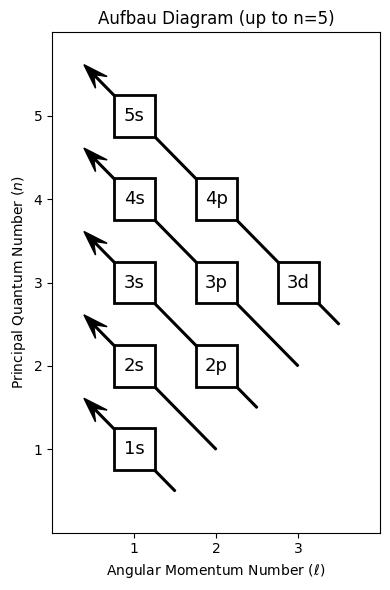

In [16]:
asdt.draw_aufbau_diagram(N_max=5, save=True, save_dir="sample_images")

Notice how some subshells with a higher _n_ sometimes fill before subshells of a lower _n_ (i.e., 4s fills before 3d). This is because these subshells (despite have a larger _n_) have a lower associated energy. Electrons will always fill into the lowest-energy subshell, regardless of what the principal quantum number is! Finding the exact energies of each subshell is tricky, and **[analytical solutions are only known for the lightest of elements](https://en.wikipedia.org/wiki/Energy_level)**.

I have made another function that explicitely writes out the filling order predicted by the Aufbau diagram. If you check the following output against the Aufbau diagram from above, you should see that they match!

In [ ]:
asdt.find_filling_order(max_level=5, joined=True)

So, what if we wanted to know the ground-state electronic configuration of a given element and ionization? To do this, we need to know...

1. The total number of available electrons
2. How many electrons can fill into each subshell

The first of these two is simple to calculate...

\begin{equation}
(\textrm{\# of available e}^-) = (\textrm{\# of protons}) - (\textrm{\# of ionized e}^-)
\end{equation}

The electron capacity of each subshell is also fairly straightforward. Each subsequent subshell has two additional orbitals. So...

| Orbital | Total Orbitals | Total e |
| :-: | :-: | :-: |
| s | 1 | 2 |
| p | 3 | 6 |
| d | 5 | 10 |
| f | 7 | 14 |
| $\vdots$ | $\vdots$ | $\vdots$ |

The following function uses this logic to convert elements (w/ formatting identical to the NIST ASD's) into a ground-state configuration. Note, this function allows for **[abbreviated notation](https://preparatorychemistry.com/Bishop_abbreviated_electron_configurations_help.htm)** and two different sorting schemes ("fill order" and "principle"). The NIST ASD defaults to "principle" sorting.

In [ ]:
asdt.find_electronic_config("O I", abbreviate=True, sortby="fill order")

Finally, it may be useful to have an automated way to tell whether a subshell is filled...

In [ ]:
config1 = asdt.find_electronic_config("Xe I", abbreviate=True, sortby="fill order").split(".")
config2 = asdt.find_electronic_config("Xe II", abbreviate=True, sortby="fill order").split(".")

print(f"Subshell '{config1[-1]}' is filled: {asdt.is_subshell_filled(config1[-1])}")
print(f"Subshell '{config2[-1]}' is filled: {asdt.is_subshell_filled(config2[-1])}")

If we look at the ASD's electronic configurations for heavy elements, there appear to be an odd format that doesn't follow the conventions laid out above. Take the following configuration data for "Ni I," for example. In addition to traditional subshells, there are terms contained within parentheses. These relate to another way of describing atoms: ___term symbols___.

In [ ]:
lines = asdt.NIST_lines(["Ni I"], keep_flag_columns=True)
np.unique(lines.df["Lower level"])

# ___What are term symbols?___

In quantum mechanics, there are **[four quantum numbers that completely describe an atom](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Quantum_Mechanics/10%3A_Multi-electron_Atoms/Quantum_Numbers_for_Atoms)**.

1. Principle Quantum Number $(n)$ <br>
2. Orbital Angular Momentum $(l)$ <br>
3. Magnetic Quantum Number $(m_l)$ <br>
4. Electron Spin Quantum Number $(m_s)$ <br>

Although we could technically explicitly write out each of these numbers for ever single atomic configuration, term symbols provide a systematic and brief way to describe all four numbers. If you have never encountered term symbols before, please read **[this helpful page](https://chem.libretexts.org/Courses/Pacific_Union_College/Quantum_Chemistry/08%3A_Multielectron_Atoms/8.08%3A_Term_Symbols_Gives_a_Detailed_Description_of_an_Electron_Configuration)** that provides an in-depth explanation of them. In order to construct a term symbol for an electronic configuration, we need to find all possible values of the above quantum numbers. Assuming there are _n_ possible ways an electron could be positioned in a subshell, and there are _k_ available electrons, the total number of unique configurations (for a single subshell) is given by the binomial coefficient...

\begin{equation}
\binom{n}{k} = \frac{n!}{k!(n-k)!}.
\end{equation}

However, some of these configurations will produce the same term symbols. This is an important point: ___"term symbols are not an exact description of how electrons are configured in a subshell."___ So, how do we go about finding all the possible term symbols associated with a given electronic configuration? I chose to implement a method outlined in **[this Wikipedia article](https://en.wikipedia.org/wiki/Term_symbol)**, and checked the output against an **[online calculator](https://umop.net/spectra/term_calc.php?config=&e=B+&i=0)**. Below, we can see every possible term symbol for a given electronic configuration...

__NOTE:__ Technically, the "generate_term_symbols" function uses a slightly-modified version of the method described above, but it is rooted in the same logic. 

In [ ]:
config = asdt.find_electronic_config("O IV")
asdt.generate_term_symbols(config)

If you compare the generated term symbols for each configuration of "Ni I" against the NIST ASD output from above, you should find a match for each line given in the database! However, there are many term symbols listed here that are not found in the NIST ASD. This is because **some quantum numbers have not been observed in a laboratory setting, despite the fact that the underlying electronic microstates are allowed.** You should note that NIST's ASD also has term symbols interspersed throughout the electronic configuration (i.e., 3d8.(3F).4s.4p.(1P*)). This intermediate terms symbols represent the term symbol of a small section of the electronic configuration (i.e., 3F for 3d8, 1P* for 4s.4p). There are some cases where NIST uses a different format for term symbols. Let's look at "Xe I," for example...

In [ ]:
lines = asdt.NIST_lines(["Xe I"], keep_flag_columns=True)
np.unique(lines.df["Lower level"])[:10]

We can see that instead of having {2S+1}L, they have something with brackets and no letter. This corresponds with a different coupling scheme, which we will not discuss in this notebook. Just note that most term symbols in the ASD assume an LS-coupling schema.

# ___Grotrian Diagrams___

The final visualization tool available produces __Grotrian Diagrams__. These diagrams allow a quick visualization of the types of transitions that are possible for a given element. Each line represents a single transition in the NIST ASD, and the color describes the type of transition at play. For elements w/ several multiplicities (i.e., singlets, doublets, etc.), each multiplicity will be separated by a faint gray line. This visualization tool is by far the roughest, and I intend to improve its functionality in future iterations.

In [ ]:
asdt.draw_grotrian_diagram("H I")